## Tool Calling and Building Agents using Langchain and Langgraph


## Section #1: Tool calling

## Section #2: Agent calling those tools

Bonus - How to return structured output from the LLM

What should already know-

1. Decorators in python- https://www.geeksforgeeks.org/decorators-in-python/
2. Pydantic class- https://www.geeksforgeeks.org/introduction-to-python-pydantic-library/

Necessary installs

In [ ]:
!pip install -q groq langchain-groq langchain langchain-community langgraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.6/129.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install -q litellm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 59.6 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata
groq_api_key = userdata.get('groq_api')
os.environ["GROQ_API_KEY"] = groq_api_key

In [ ]:
from langchain_groq import ChatGroq
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, ToolMessage, AIMessage
from langgraph.prebuilt import create_react_agent
from typing import List
from litellm import completion
from langchain.agents import initialize_agent, Tool, AgentType

In [ ]:
# from langchain_groq import ChatGroq

llm = ChatGroq(
    model="llama-3.3-70b-versatile", #"llama-3.1-8b-instant",
    temperature=0, # range of temperature variable is from 0(least artistic) to 1(most artistic/enhanced)
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

When we build LLM Applications - Getting the correct answer is challenging.

Parameters to tune while building an AI applications:

1. temperature
2. prompt tuning
3. tokens

Tradeoff between Accuracy and Response time.



## Section #1: What are Tools?

- APIs
- Database queries
- Internal services
- Third-party systems
- Internal function



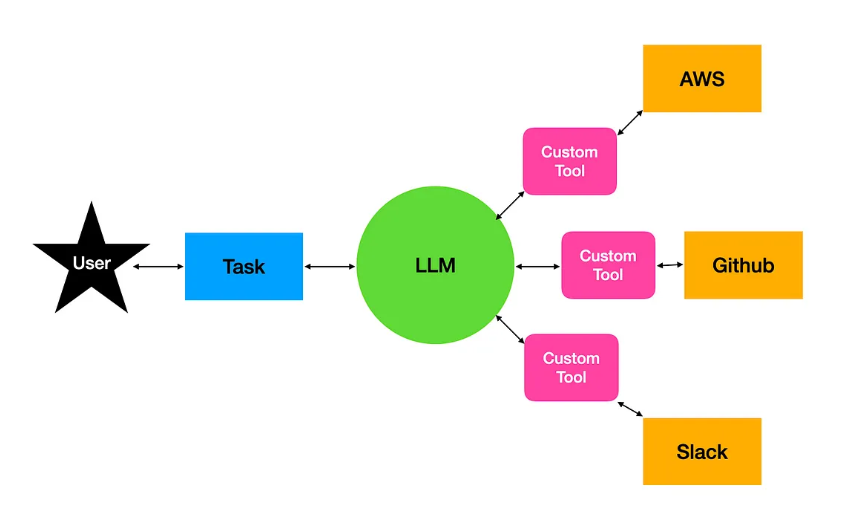

## Tool Calling using Langchain:

1) Tool Creation

2) Tool Binding

3) Tool Calling

Ref- http://python.langchain.com/docs/concepts/tool_calling/

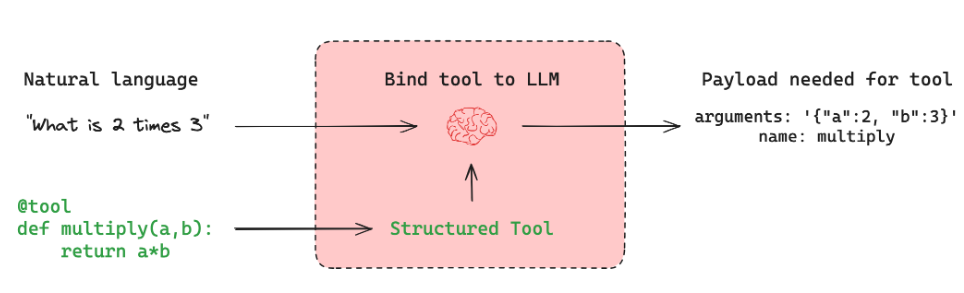

1) **Creating a Tool**: You start by using the @tool decorator to define a tool. This links a Python function with a clear structure (schema) that tells the model what kind of input it expects.

2) **Connecting the Tool to a Model**: After creating the tool, you connect it to a model that can use tools. This step helps the model understand that the tool exists and what type of input it needs.

3) **Calling the Tool**: Once the model understands the tool, it can choose to use it when answering a query — as long as the input format matches the tool’s schema.

4) **Running the Tool**: Finally, the model provides the required inputs, and the tool is executed just like a regular function call.












In [ ]:
# from langchain_core.tools import tool


@tool
def add(a: int, b: int) -> int:
    """Adds a and b."""
    print("this is the addition tool")
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiplies a and b."""
    return a * b


tools = [add, multiply]

In [ ]:
# from pydantic import BaseModel, Field


# Note that the docstrings here are crucial, as they will be passed along
# to the model along with the class name.
class Add(BaseModel):
    """Add two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


class Multiply(BaseModel):
    """Multiply two integers together."""

    a: int = Field(..., description="First integer")
    b: int = Field(..., description="Second integer")


tools = [Add, Multiply]

In [ ]:
# Tool binding
llm_with_tools = llm.bind_tools(tools)

In [ ]:
query = "What is 3 * 12?"
response = llm_with_tools.invoke(query)
print(response)

content='' additional_kwargs={'tool_calls': [{'id': 'call_jg9d', 'function': {'arguments': '{"a":3,"b":12}', 'name': 'Multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 295, 'total_tokens': 314, 'completion_time': 0.069090909, 'prompt_time': 0.018755339, 'queue_time': 0.210936496, 'total_time': 0.087846248}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_3f3b593e33', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--64371af3-a2d8-46ec-9025-80be90171705-0' tool_calls=[{'name': 'Multiply', 'args': {'a': 3, 'b': 12}, 'id': 'call_jg9d', 'type': 'tool_call'}] usage_metadata={'input_tokens': 295, 'output_tokens': 19, 'total_tokens': 314}


In [ ]:
query = "Hello"
response = llm_with_tools.invoke(query)
print(response)

content="I'm here to help with any questions or tasks you may have. What would you like to know or do today?" additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 288, 'total_tokens': 313, 'completion_time': 0.090909091, 'prompt_time': 0.01917244, 'queue_time': 0.20008561400000002, 'total_time': 0.110081531}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None} id='run--0fe9f378-e205-4df9-a36c-56818c6d2bf4-0' usage_metadata={'input_tokens': 288, 'output_tokens': 25, 'total_tokens': 313}


In [ ]:
# from langchain_core.messages import HumanMessage, ToolMessage

messages = [HumanMessage(query)]
ai_msg = llm_with_tools.invoke(messages)

messages.append(ai_msg)
for tool_call in ai_msg.tool_calls:
    selected_tool = {"add": add, "multiply": multiply}[tool_call["name"].lower()]
    tool_output = selected_tool.invoke(tool_call["args"])
    messages.append(ToolMessage(tool_output, tool_call_id=tool_call["id"]))
messages

[HumanMessage(content='Hello', additional_kwargs={}, response_metadata={}),
 AIMessage(content="I'm here to help with any questions or tasks you may have. What would you like to know or do today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 288, 'total_tokens': 313, 'completion_time': 0.125711275, 'prompt_time': 0.019470777, 'queue_time': 0.202256617, 'total_time': 0.145182052}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_2ddfbb0da0', 'finish_reason': 'stop', 'logprobs': None}, id='run--9562055b-bf8e-4644-8052-19198ad37ab7-0', usage_metadata={'input_tokens': 288, 'output_tokens': 25, 'total_tokens': 313})]

## Section #2: What are Agents?


- Technically: Agents = LLM + Tools + Planning + Memory
- Definition: an agent is a system that uses an LLM to decide the control flow of an application.
- Think upon : How much control should be given to an Agent?
- Fully autonomous or semi-autonomous or Human-in-the-Loop ?
- How to give control? LLMs can be used-
   - to choose a path amongts multiple pipelines
   - to decide which tools out of the available tools to use
   - if the generated answer is satifactory or further review &
     improvement is required.

## Agent Creation

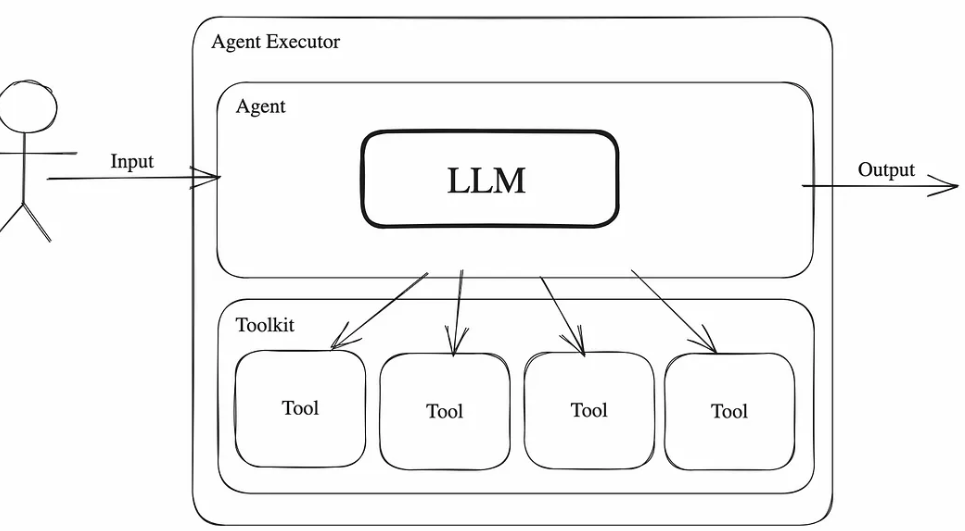

In [ ]:
# from langgraph.prebuilt import create_react_agent
# from langchain_core.messages import HumanMessage, AIMessage, ToolMessage
model = llm_with_tools
agent_executor = create_react_agent(model, tools)

In [ ]:
response = agent_executor.invoke({"messages": [HumanMessage(content="hi im bob! i want to know what is 11 + 49")]})
# print(response)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

The result of 11 + 49 is 60.


In [ ]:
response["messages"][-1].content

'The result of 11 + 49 is 60.'

## Let's build a real use case pipeline

Consider a Tele Agent(customer care executive) and customer conversation. We want to create two tools:

1. Perform sentiment analysis of the customer from the conversation to find out if the customer was satisfied. And provide a score.

2. How can the Tele Agent improve to give better solution to the customer.


Steps:

1. Scope of questions

**Tool #1: Sentiment analysis**

In [ ]:
# from litellm import completion
@tool
def analyze_customer_sentiment(conversation: str):
    """
    Analyzes a customer-agent conversation to extract:
    1. The customer's sentiment (e.g., happy, angry, satisfied)
    2. A customer satisfaction score (1 to 5)

    Parameters:
    - conversation (str): The full conversation between the agent and the customer.

    Returns:
    - SentimentOutput: Contains sentiment and score, parsed and validated by the Pydantic model.
    """

    # Prompt tells the LLM exactly what to do and restricts it from returning anything extra.
    prompt = f"""
    You are an expert in sentiment analysis.

    Analyze the given conversation {conversation} between a customer care agent and a customer and extract the following:
    1. Customer's Sentiment (happy, sad, angry, satisfied, unsatisfied, etc.)
    2. Customer's satisfaction score on a scale from 1 to 5, where 1 is the lowest score and 5 is the highest score.
    """

    #using chatgroq from langchain
    response = llm.invoke(prompt)
    cleaned_output = response.content.strip()
    return cleaned_output


Quick check

In [ ]:
conversation= """
Agent: Good morning! Thank you for calling customer support. How can I help you today?
Customer: I’ve been charged twice for my internet bill and it’s really frustrating.
Agent: I'm sorry to hear that. Let me take a look.
Customer: This is the second time it’s happening. I’m tired of calling you guys.
Agent: I understand. I’ve reversed the duplicate charge. It should reflect in 24 hours.
Customer: Alright. Just make sure it doesn’t happen again.
"""
res = analyze_customer_sentiment(conversation)
print(res)

<ipython-input-17-3e363c8a5c44>:9: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  res = analyze_customer_sentiment(conversation)


Based on the conversation, I would analyze the customer's sentiment and satisfaction score as follows:

1. **Customer's Sentiment:** The customer's sentiment is primarily **angry** and **frustrated**. The customer mentions that they are "really frustrating" and "tired of calling" the customer support, indicating a strong negative emotion. However, towards the end of the conversation, the customer's tone becomes slightly **neutral** or **cautiously optimistic**, as they seem to accept the agent's solution.

2. **Customer's Satisfaction Score:** I would rate the customer's satisfaction score as a **3** out of 5. The customer is clearly unhappy with the initial issue (being charged twice) and the fact that it's happened before. However, the agent's prompt response and resolution of the issue (reversing the duplicate charge) seem to have mitigated the customer's anger to some extent. The customer's final statement, "Just make sure it doesn't happen again," suggests that they are still wary

**Results with Pydantic class: Make the LLM output a well-defined Schema**

In [ ]:
# from typing import List
class SentimentOutput(BaseModel):
    """
    Defines the structured output schema that the LLM must follow.

    Fields:
    - sentiment: Customer sentiment as a string (happy, angry, etc.)
    - score: Satisfaction score from 1 to 5 as an integer
    """
    sentiment: str = Field(description="Sentiment of the customer in the conversation")
    score: int = Field(description="Customer satisfaction score on a scale of 1 to 5")

class CommunicationFeedback(BaseModel):
    """
    Defines the structured output schema that the LLM must follow.

    Fields:
    - improvements: Areas for improvement in communication style of the Agent
    """
    improvements: List[str] = Field(description="List of specific areas where the tele agent can improve their communication style")


In [ ]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=SentimentOutput)

from litellm import completion
@tool
def analyze_customer_sentiment2(conversation: str) -> SentimentOutput:
    """
    Analyzes a customer-agent conversation to extract:
    1. The customer's sentiment (e.g., happy, angry, satisfied)
    2. A customer satisfaction score (1 to 5)

    Parameters:
    - conversation (str): The full conversation between the agent and the customer.

    Returns:
    - SentimentOutput: Contains sentiment and score, parsed and validated by the Pydantic model.
    """

    # Prompt tells the LLM exactly what to do and restricts it from returning anything extra.
    prompt = f"""
    You are an expert in sentiment analysis.

    Analyze the given conversation {conversation} between a customer care agent and a customer and extract the following:
    1. Customer's Sentiment (happy, sad, angry, satisfied, unsatisfied, etc.)
    2. Customer's satisfaction score on a scale from 1 to 5, where 1 is the lowest score and 5 is the highest score.
    3. Do not add any notes and additional comments or explanations.

    Strictly respond following the below schema:
    {parser.get_format_instructions()}
    """
    response = llm.invoke(prompt)
    cleaned_output = response.content.strip()
    return cleaned_output

Quick check

In [ ]:
conversation= """
Agent: Good morning! Thank you for calling customer support. How can I help you today?
Customer: I’ve been charged twice for my internet bill and it’s really frustrating.
Agent: I'm sorry to hear that. Let me take a look.
Customer: This is the second time it’s happening. I’m tired of calling you guys.
Agent: I understand. I’ve reversed the duplicate charge. It should reflect in 24 hours.
Customer: Alright. Just make sure it doesn’t happen again.
"""
res = analyze_customer_sentiment2(conversation)
print(res)

```
{
  "sentiment": "unsatisfied",
  "score": 3
}
```


**Tool #2: Agent communication style analysis**

Remember to change the parser

In [ ]:
parser = PydanticOutputParser(pydantic_object=CommunicationFeedback)

@tool
def analyze_agent_communication(conversation: str) -> CommunicationFeedback:
    """Analyzes the communication style of the tele agent andonly return areas for improvement.
     Parameters:
    - conversation (str): The full conversation between the agent and the customer.

    Returns:
    - Areas of improvement in communication style List[str] : Contains list of areas where the agent can improve in order to improve customer satisfcaction.
    """

    # Prompt tells the LLM exactly what to do and restricts it from returning anything extra.
    prompt = f"""
    You are an expert in conversation analysis.

    Analyze the given conversation {conversation} between a customer care agent and a customer.
    And give a list of specific areas where the tele agent can improve their communication style
    to improve the customer experience.
    Do not add any notes and additional comments or explanations.

    Strictly respond following the below schema:
    {parser.get_format_instructions()}
    """
    response = llm.invoke(prompt)
    cleaned_output = response.content.strip()
    return cleaned_output


Quick check

In [ ]:
result = analyze_agent_communication(conversation)
print(result)

{"improvements": [
    "Acknowledge the customer's frustration and show empathy",
    "Provide a clear explanation of the solution and the timeline for resolution",
    "Offer a preventive measure to avoid similar issues in the future",
    "Ask for the customer's confirmation and satisfaction before closing the issue",
    "Use a more personalized and apologetic tone to show that the issue is taken seriously",
    "Provide additional assistance or support to prevent the customer from having to call again",
    "Explain the process to ensure that the duplicate charge does not happen again"
]}


- Create your tools list
- Bind it with the LLM
- Feed it into the Agent Executor

In [ ]:
new_tools = [
    Tool(
        name="SentimentAnalysisTool",
        func=analyze_customer_sentiment2,
        description="""Use this tool to analyze the customer's sentiment (e.g., happy, sad, angry, unsatisfied) and
        give a satisfaction score (1–5) from a conversation. Use this for questions about the *customer's* mood or satisfaction."""
    ),
    Tool(
        name="AgentFeedbackTool",
        func=analyze_agent_communication,
        description="""Use this tool to give feedback on the tele-agent’s communication style and suggest areas for improvement.
        Use this for questions about how the *agent* could have communicated better."""
    )
]

#Bind the LLM with your tools
llm_with_new_tools = llm.bind_tools(new_tools)

In [ ]:
# model = llm
# new_tools = [analyze_customer_sentiment2, analyze_agent_communication]
llm_with_new_tools = llm.bind_tools(new_tools)

Create your agent

In [ ]:
from langchain.agents import create_tool_calling_agent


In [ ]:
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are an expert evaluator of customer service conversations. Use tools when needed."),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}")  # <--- Required for tool call reasoning
])

# Create the agent
agent = create_tool_calling_agent(llm, new_tools, prompt)

# Wrap in executor
agent_executor = AgentExecutor(agent=agent, tools=new_tools, verbose=True)

In [ ]:
agent_executor = create_react_agent(llm_with_new_tools, new_tools)

In [ ]:
conversation= """
Agent: Good morning! Thank you for calling customer support. How can I help you today?
Customer: I’ve been charged twice for my internet bill and it’s really frustrating.
Agent: I'm sorry to hear that. Let me take a look.
Customer: This is the second time it’s happening. I’m tired of calling you guys.
Agent: I understand. I’ve reversed the duplicate charge. It should reflect in 24 hours.
Customer: Alright. Just make sure it doesn’t happen again.
"""

In [ ]:
response = agent_executor.invoke({
    "input": f"What should the tele agent learn from this conversation?\n{conversation}"
})



> Entering new AgentExecutor chain...

Invoking: `AgentFeedbackTool` with `The agent was apologetic and resolved the issue promptly, but could have also offered additional solutions or preventative measures to prevent the duplicate charge from happening again in the future, such as reviewing the customer's billing settings or providing information on how to monitor their account activity.`


{"improvements": ["Offering additional solutions", "Providing preventative measures", "Reviewing customer's billing settings", "Providing information on monitoring account activity", "Proactive communication to prevent future issues", "Empathizing with the customer's frustration", "Clearly explaining the resolution process", "Following up to ensure the issue is fully resolved"]}
Invoking: `SentimentAnalysisTool` with `The customer was initially frustrated and angry about being charged twice, but seemed somewhat satisfied with the agent’s resolution of reversing the duplicate charge. However, the 

In [ ]:
response1 = agent_executor.invoke({
    "input": f"What is the customer satisfaction score in this conversation?\n{conversation}"
})




> Entering new AgentExecutor chain...

Invoking: `SentimentAnalysisTool` with `I’ve been charged twice for my internet bill and it’s really frustrating. This is the second time it’s happening. I’m tired of calling you guys. Alright. Just make sure it doesn’t happen again.`


```
{
  "customer_sentiment": "angry",
  "customer_satisfaction_score": 1
}
```The customer satisfaction score in this conversation is 2. The customer is frustrated and angry about being charged twice for their internet bill, but the agent is able to resolve the issue by reversing the duplicate charge. However, the customer's tone and language suggest that they are still dissatisfied with the overall experience and are warning the agent to ensure it doesn't happen again.

> Finished chain.


In [ ]:
response1 = agent_executor.invoke({
    "input": f"What is the customer satisfaction score in this conversation?\n{conversation}"
})

print("Full raw response:\n", response1)

# If it's a string output:
if isinstance(response1, dict) and "output" in response1:
    print("Agent says:\n", response1["output"])




> Entering new AgentExecutor chain...

Invoking: `SentimentAnalysisTool` with `I’ve been charged twice for my internet bill and it’s really frustrating. This is the second time it’s happening. I’m tired of calling you guys. Alright. Just make sure it doesn’t happen again.`


```
{
  "customer_sentiment": "angry",
  "customer_satisfaction_score": 1
}
```The customer satisfaction score in this conversation is 2. The customer is frustrated and angry about being charged twice for their internet bill, and they express their dissatisfaction with the company's service. Although the agent resolves the issue, the customer's overall tone and language suggest a low level of satisfaction.

> Finished chain.
Full raw response:
 {'input': "What is the customer satisfaction score in this conversation?\n\nAgent: Good morning! Thank you for calling customer support. How can I help you today?\nCustomer: I’ve been charged twice for my internet bill and it’s really frustrating.\nAgent: I'm sorry to hear

In [ ]:
print(response1)

{'input': "What is the customer satisfaction score in this conversation?\n\nAgent: Good morning! Thank you for calling customer support. How can I help you today?\nCustomer: I’ve been charged twice for my internet bill and it’s really frustrating.\nAgent: I'm sorry to hear that. Let me take a look.\nCustomer: This is the second time it’s happening. I’m tired of calling you guys.\nAgent: I understand. I’ve reversed the duplicate charge. It should reflect in 24 hours.\nCustomer: Alright. Just make sure it doesn’t happen again.\n", 'output': "The customer satisfaction score in this conversation is 2. The customer is frustrated and angry about being charged twice for their internet bill, but the agent is able to resolve the issue by reversing the duplicate charge. However, the customer's tone and language suggest that they are still dissatisfied with the overall experience and are warning the agent to ensure it doesn't happen again."}


## Assignment: Building a Smart Assistant for Virtual Healthcare Support

You are hired by a startup called CareConnect, which is building an AI-powered assistant to support virtual healthcare providers. This assistant will help nurses, doctors, and patients by analyzing chat transcripts of telehealth sessions.

Your job is to design LangChain tools and build an intelligent agent that can dynamically invoke the right tool based on what the user is asking.

 **Problem Statement**:
Given a doctor-patient conversation, the AI assistant should help by:


*   Detecting the patient's emotional state. Give a score on a scale of 1-5.
*   Summarizing the chief complaint and urgency of the patient.
